<b>Dans ce notebook on nettoie le dataset sur la base des éléments décrits par le notebook Describe_Dataset</b>

# Table of contents
1. [Load du dataset](#load)
2. [Mise à l'écart des données US](#purge_us)
3. [Mise à l'écart des features redondantes](#purge_redund)
4. [Mise à l'écart des features 100% NaN](#purge_nan)
5. [Regroupement des PNNS](#pnns)
6. [Traitement des outliers](#outliers) 
7. [Imputations](#imputations)

    7.1 [High density features](#impute_high_density)
    
    7.2 [Mid density features](#impute_mid_density)
   


<b  style="background-color:tomato;font-size:14px;">1. LOAD DU DATASET<b>
    <a id="load"></a>   

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

try:
    del data
except:
    dummy=1

#On ne prend qu'un échantillon du fait des limitations mémoire de la machine
data=pd.read_csv('../dataset/en.openfoodfacts.org.products.csv',sep='\t',nrows=300000)

/home/alpro/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,12,18,19,20,21,22,26,27,28,30,51) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<b  style="background-color:tomato;font-size:14px;">2. MISE A L'ECART DES DONNEES US<b>
    <a id="load"></a>  

In [ ]:
us_to_remove = data[data['countries_tags']=="en:united-states"]
#us_to_remove = data['countries_tags']
len(us_to_remove)

<b  style="background-color:tomato;font-size:14px;">3. MISE A L'ECART DES FEATURES REDONDANTES<b>
    <a id="load"></a>  

In [ ]:
columns_to_remove = []
for s in data.columns:
    if "_tags" in s: 
        t = s.replace('_tags', '')
        u = s.replace('_tags', '_en')
        print("{:<20} 'no suffix' -> {} ; '_en' suffix -> {}".format(s,t in data.columns, u in data.columns))
        if t in data.columns: columns_to_remove.append(t)
        if u in data.columns: columns_to_remove.append(u)
data.drop(columns_to_remove, axis = 1, inplace = True)

<b  style="background-color:tomato;font-size:14px;">4. MISE A L'ECART DES FEATURES 100% NaN<b>
    <a id="load"></a>  

In [2]:
percent_of_nans = data.isnull().sum().sort_values(ascending=False) / data.shape[0] * 100

In [ ]:
useless_features = percent_of_nans[percent_of_nans == 100].index
print(useless_features)
data.drop(useless_features, axis=1, inplace=True)
data.shape

<b  style="background-color:tomato;font-size:14px;">5. REGROUPEMENT DES PNNS<b>
    <a id="load"></a>  

<b  style="background-color:tomato;font-size:14px;">6. TRAITEMENT DES OUTLIERS<b>
    <a id="load"></a>  

<b  style="background-color:tomato;font-size:14px;">7. IMPUTATIONS<b>
    <a id="load"></a>  

<b  style="background-color:tomato;font-size:12px;">&nbsp;&nbsp;&nbsp;&nbsp;7.1. HIGH DENSITY FEATURES<b>
    <a id="load"></a>  

In [25]:
from sklearn.impute import KNNImputer
pd.options.mode.chained_assignment = None
import math

def knn_imputation(df_knn,nn):
    
    imputer = KNNImputer(n_neighbors=nn, weights='uniform', metric='nan_euclidean')
    
    #print(df_knn)
    
    df_filled = imputer.fit_transform(df_knn)
    #print(type(df_filled))
    #print('---------------------')
    #print(df_filled[:,1])
    #print('---------------------')
    return df_filled[:,1]

def mean_imputation(df,feature):
    print('mean imputation')
    print('feature = ' + feature)
    print(df.head())
    df_feature_mean = df[feature].mean()
    df.loc[(df[feature].isnull()),feature]=df_feature_mean

    print('---------------------')
    print(df[feature])
    print('---------------------')
    
    return df[feature]

def imputation(data,features,type):
    mean_updates=pd.DataFrame()
    mean_dict={"feature":[],"original_mean":[],"original_std":[],"new_mean":[],"new_std":[]}

    for feature in features.index:
        print('******* ' + feature)    
        subset = data[['categories_tags',feature]]

        #valuate mean and standard deviation before knn algorithm
        feature_mean = subset[feature].mean()
        feature_std = subset[feature].std()
        feature_mean_new = feature_mean
        feature_std_new = feature_std
        print('    - mean = ' + str(feature_mean))
        print('    - std = ' + str(feature_std))

        subset = subset[subset["categories_tags"].notna()]
        #print(subset.head())

        i=[]
        for k in range(subset.shape[0]):
            i.append(0)
        #add dummy column as knn only works at least 2 numerical columns subsets     
        subset['dummy']=i
        cpt=0
        for col in subset['categories_tags'].unique():
            print('* ' + col)
            subset_cat=subset.loc[data['categories_tags'] == col]
            #print(str(len(subset_cat)))
            #print(subset_cat.head())

            #We don't try imputation if category does not have a single valuated row or if category does not have any nan
            if not (math.isnan(feature_mean) or subset_cat[feature].isnull().values.any() == 0):
                subset_imputation=subset_cat[['dummy',feature]]
                if type == "knn":
                    new_values = knn_imputation(subset_imputation,2)
                if type == "mean":
                    new_values = mean_imputation(subset_imputation,feature)
                subset_cat['newvalues']=new_values
                #print(subset_cat)

                #Identify row index where values has been changed. Update with imputed value in the dataframe.
                #print('changed indexes')
                #print('---------------')
                changed_values=subset_cat.loc[(subset_cat[feature] != subset_cat['newvalues'])]
                #print(changed_values)
                for d in changed_values.index:
                    print('**** '+ str(d) + ' ---> ' + str(changed_values.at[d,'newvalues']))
                    data.at[d, feature] = changed_values.at[d,'newvalues']
            cpt = cpt +1
            if cpt == 5:
                break
            
        subset = data[['categories_tags',feature]]
        feature_mean_new = subset[feature].mean()
        feature_std_new = subset[feature].std()
        print('    - mean = ' + str(feature_mean_new))
        print('    - std = ' + str(feature_std_new))

        mean_dict["feature"].append(feature)
        mean_dict["original_mean"].append(feature_mean)
        mean_dict["original_std"].append(feature_std)
        mean_dict["new_mean"].append(feature_mean_new)
        mean_dict["new_std"].append(feature_std_new)
        
        break         
            


    #print(df)
    mean_updates=pd.DataFrame(mean_dict)
    #print(mean_updates)

    plt.figure(figsize=(20,5))
    means = sns.lineplot(data=mean_updates)
    plt.title("Imputation par " + type + " - Evolution des moyennes et écart type par catégories imputées")
    plt.ylabel("Mean/std")
    try:
        del subset
        del subset_imputation
        del subset_cat
        del mean_updates
    except:
        k=0

******* saturated-fat_100g
    - mean = 4.882342026746706
    - std = 8.436184489622317
* en:groceries,en:condiments,en:sauces,en:mustards
* fr:xsf
* fr:pate-d-amende
* en:meals,en:prepared-vegetables,en:grated-carrots,en:seasoned-shredded-carrots
* en:pies,en:sweet-pies,en:coconut-pies
    - mean = 4.882342026746706
    - std = 8.436184489622317


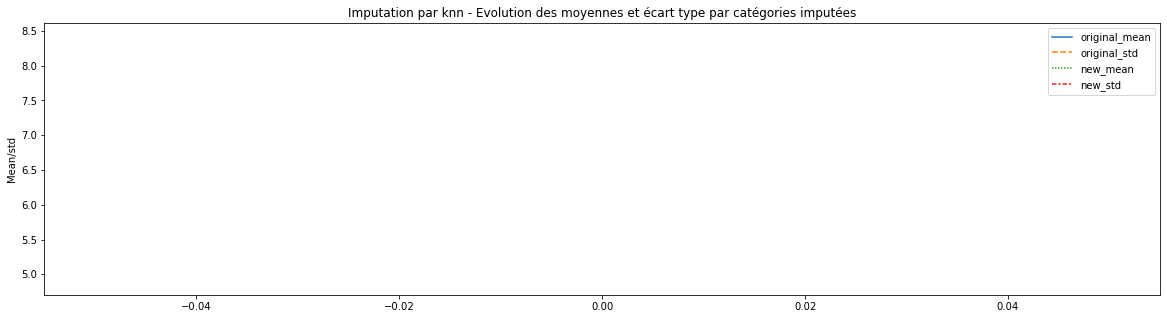

In [26]:
to_be_completed = percent_of_nans[(percent_of_nans < 25) & (percent_of_nans > 0)]
to_be_completed_high_density = to_be_completed.filter(like='_100g')
imputation(data,to_be_completed_high_density,'knn')

<b  style="background-color:tomato;font-size:12px;">&nbsp;&nbsp;&nbsp;&nbsp;7.2. MID DENSITY FEATURES<b>
    <a id="load"></a>  

******* calcium_100g
    - mean = 0.10836789631290435
    - std = 1.857018187350552
* en:groceries,en:condiments,en:sauces,en:mustards
* fr:xsf
mean imputation
feature = calcium_100g
   dummy  calcium_100g
4      0           NaN
---------------------
4   NaN
Name: calcium_100g, dtype: float64
---------------------
**** 4 ---> nan
* fr:pate-d-amende
mean imputation
feature = calcium_100g
    dummy  calcium_100g
12      0           NaN
---------------------
12   NaN
Name: calcium_100g, dtype: float64
---------------------
**** 12 ---> nan
* en:meals,en:prepared-vegetables,en:grated-carrots,en:seasoned-shredded-carrots
mean imputation
feature = calcium_100g
        dummy  calcium_100g
13          0           NaN
1859        0           NaN
259984      0           NaN
260670      0           NaN
261093      0           NaN
---------------------
13       NaN
1859     NaN
259984   NaN
260670   NaN
261093   NaN
261097   NaN
261940   NaN
264239   NaN
265776   NaN
266223   NaN
267590   NaN
2685

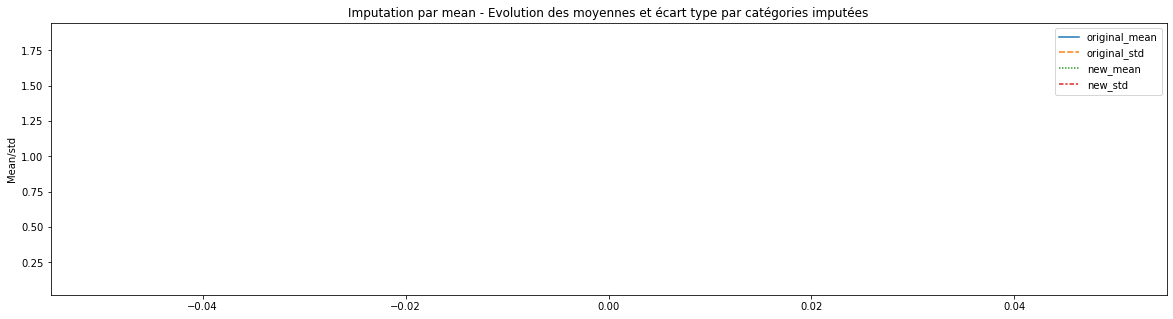

In [27]:
to_be_completed = percent_of_nans[(percent_of_nans < 50) & (percent_of_nans >= 25 )]
to_be_completed_average_density = to_be_completed.filter(like='_100g')
imputation(data,to_be_completed_average_density,'mean')